# Определение возраста покупателей

## Исследовательский анализ данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Изучим csv-файл : по идее по нему можно понять сколько всего мы ожидаем фотографий людей для обучающей выборки + сможем построить распределение возраста

In [2]:
labels_age_data = pd.read_csv('/datasets/faces/labels.csv')

Выведем полученный файл на осмотр:

In [3]:
display(labels_age_data)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Проверим, что все названия фото уникальны:

In [4]:
print(f'{len(labels_age_data["file_name"].unique())} = {labels_age_data.shape[0]}')

7591 = 7591


Посмотрим распределение возраста:

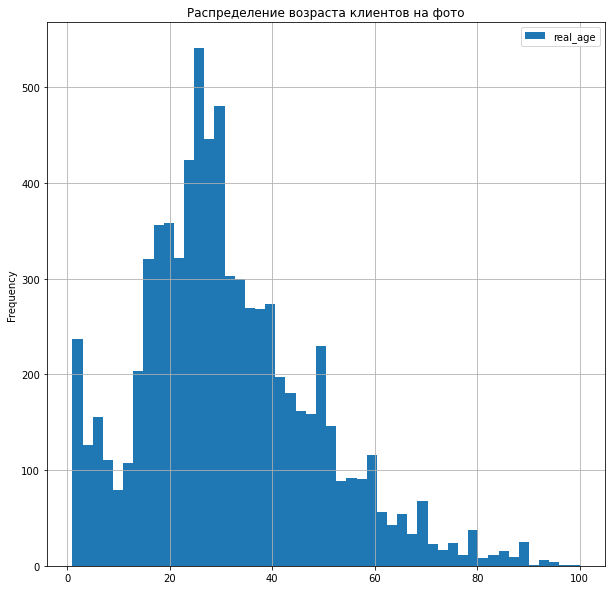

In [5]:
labels_age_data.plot(kind='hist', y='real_age', bins=50, figsize=(10, 10), grid=True,
                    title='Распределение возраста клиентов на фото');

In [6]:
labels_age_data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Минимальный возраст - 1, максимальный - 100 , средний - 31. Распределение близко к нормальному.

Можем сказать, что данные выглядят вполне правдоподобно и среди них нет выбросов или нереалистичного распределения

Теперь извлечём и посмотрим фотографии:

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels_age_data,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    seed=0
)

Found 7591 validated image filenames.


Фото загружены - посмотрим на первые 15 из них

Возраст человека на фото ниже : 40


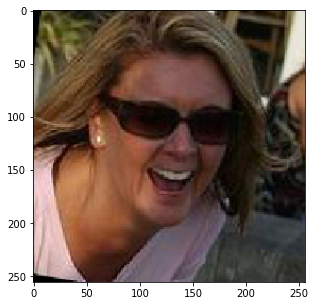

Возраст человека на фото ниже : 46


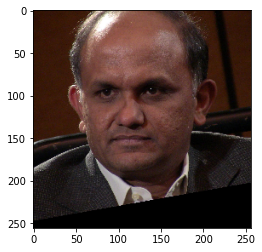

Возраст человека на фото ниже : 62


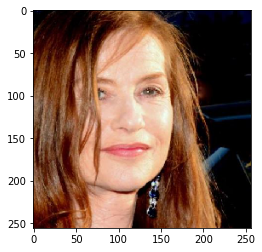

Возраст человека на фото ниже : 25


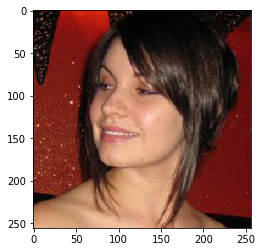

Возраст человека на фото ниже : 35


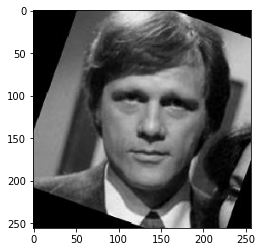

Возраст человека на фото ниже : 38


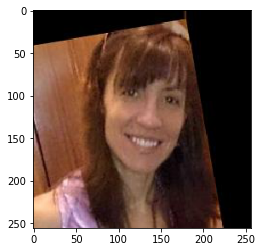

Возраст человека на фото ниже : 25


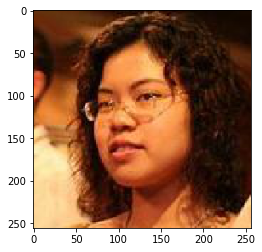

Возраст человека на фото ниже : 60


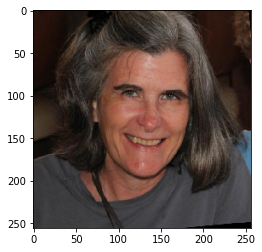

Возраст человека на фото ниже : 24


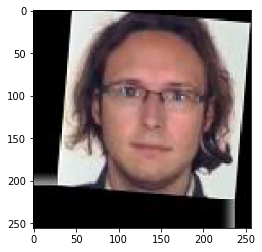

Возраст человека на фото ниже : 19


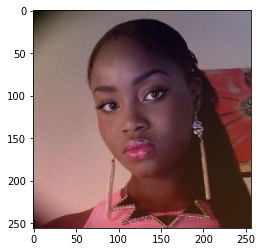

Возраст человека на фото ниже : 25


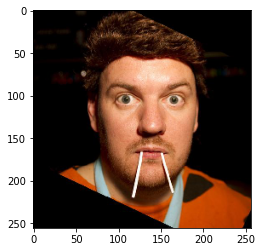

Возраст человека на фото ниже : 50


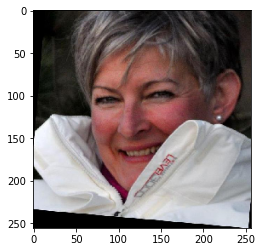

Возраст человека на фото ниже : 24


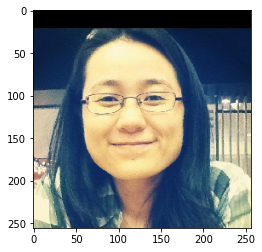

Возраст человека на фото ниже : 28


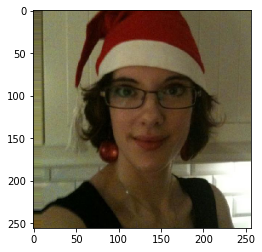

Возраст человека на фото ниже : 13


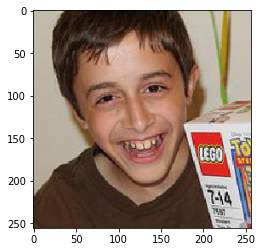

In [8]:
features, target  = next(train_gen_flow)

plt.figure(figsize=(5, 5))

for i in range(15):
    plt.imshow(features[i])
    print(f'Возраст человека на фото ниже : {target[i]}')
    plt.show()

Как видно - значения возраста вполне совпадают с изображениями людей, но конечно нельзя не заметить, что сами по себе фото весьма разнородные, что может усложнить воспринятие моделью обучающей выборки : встречаются фото сильно разного качества, с обрезанными углами, часто лицо закрыто руками/головными уборами/очками (на некоторых прогонках данного ноутбука встречал даже фото, где вообще не было видно лица человека, а возраст можно предсказать лишь по телосложению). Да и само число изображений - всего около 7000 , как я понимаю - для обучения нейросести это не такой уж большой объём, что вероятно скажется так же на качестве не в лучшую сторону (возможно хорошей идеей будет покрутить фото для увеличения тренировочной выборки).

Но в любом случае - критических моментов, которые бы помешали создать модель по данному набору данных - нет

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels_age_data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_age_data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        class_mode='raw',
        seed=0
    )
    return train_gen_flow


def load_test(path):
    labels_age_data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_age_data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        class_mode='raw',
        seed=0
    )
    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >

Train for 178 steps, validate for 60 steps
Epoch 1/5
2022-06-16 20:32:43.012610: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-16 20:32:45.254731: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 209.2947 - mae: 10.5359 - val_loss: 927.9386 - val_mae: 25.6172
Epoch 2/5
178/178 - 40s - loss: 75.9402 - mae: 6.5572 - val_loss: 709.4006 - val_mae: 21.5820
Epoch 3/5
178/178 - 40s - loss: 49.8447 - mae: 5.3608 - val_loss: 413.8028 - val_mae: 15.3115
Epoch 4/5
178/178 - 40s - loss: 34.9606 - mae: 4.5096 - val_loss: 136.0266 - val_mae: 8.5104
Epoch 5/5
178/178 - 40s - loss: 26.6699 - mae: 3.9717 - val_loss: 84.2305 - val_mae: 6.9920
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 84.3425 - mae: 7.0101
Test MAE: 7.0101

```

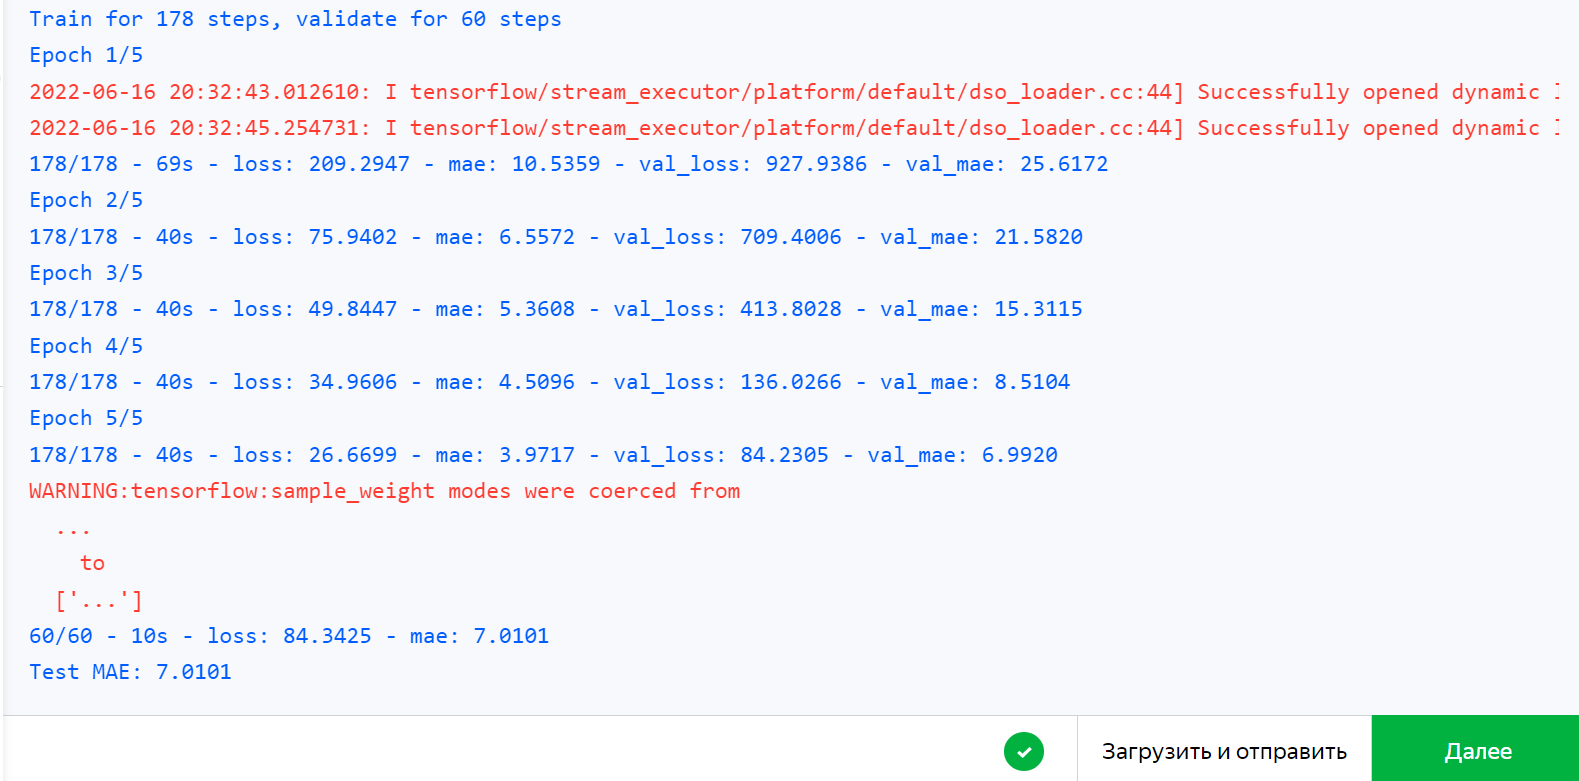

## Анализ обученной модели

Даже несмотря на выше прописанное несовершенство исходных фото - удалось всего за 5 эпох добиться весьма хороших показателей метрики качества (в данном случае это MAE ~ 7). Очевидно если увеличивать число эпох до условных 10, то судя по тенденции показателей в выводе GPU-тренажера - результаты можно было бы улучшать и ещё, либо же задать какое-нибудь дополнительное кручение/отражение исходных фото для увеличения объёма тренировочной выборки, но так как ResNet весьма долго считает каждую эпоху, да и очередь на сервер идет 2-3 часа - ограничился небольшим числом эпох, чтобы время обучения не было слишком большим.

Думаю по соотношению (время обучения и нагрузка на сервер)/(качество модели) - можно сказать что всё получилось весьма оптимально и успешно.